In [1]:
# 기본
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 경고 뜨지 않게 설정
import warnings
warnings.filterwarnings('ignore')

# 그래프 설정
sns.set()

# 그래프 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

# 데이터 전처리 알고리즘
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# 학습용과 검증용으로 나누는 함수
from sklearn.model_selection import train_test_split

# 교차 검증
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

# 평가함수
# 분류용
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# 회귀용
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# 모델의 최적의 하이퍼 파라미터를 찾기 위한 도구
from sklearn.model_selection import GridSearchCV

# 머신러닝 알고리즘 - 분류
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

# 머신러닝 알고리즘 - 회귀
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor

from scipy.stats import f_oneway
from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import kstest, norm
import scipy.stats as stats
from scipy.stats import spearmanr
from sklearn.preprocessing import PowerTransformer

# 차원 축소
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# 군집
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth

# 학습 모델 저장을 위한 라이브러리
import pickle

### 가설1 : Segment 등급이 높을수록 최근 3개월간 카드 이용금액이 높을 것이다.
 1) 컬럼 : Segment, 이용금액_R3M_신용체크
 2) 분석 방법 : ANOVA, Spearman 상관분석, Boxplot
 3) 인사이트
  - 신용/체크카드 이용금액이 클수록 A,B 등급에 분포될 가능성이 높다.

In [2]:
# 데이터를 불러온다.
df = pd.read_parquet("data/r05.parquet")
# df

In [3]:
# 필요한 컬럼 추출
df_g1 = df[['Segment', '이용금액_R3M_신용체크']].dropna()

### ANOVA 분석
 - Segment 등급에 따라 이용금액 평균이 달라지는지에 대한 분석

In [4]:
# Segment 그룹별 개수 확인
print(df_g1['Segment'].value_counts())
# 이용금액_R3M_신용체크 최댓값
df['이용금액_R3M_신용체크'].min()
# 그룹별 개수를 확인한 결과 극단적인 불균형을 확인 가능
# 이렇게 되면 분산분석은 수치적으로 크게 왜곡 될 가능성이 많음.
# 해결 전략 : 등급별 샘플 수 균형 맞추기

Segment
E    69193872
D    12572712
C     4593240
A       34992
B        5184
Name: count, dtype: int64


-8749

In [5]:
# 등급별 샘플 수 균형 맞추기
# 샘플 수 기준: 가장 작은 등급 B에 맞추기
n = 5000  
# 등급별 샘플링
df_sampled = df_g1.groupby('Segment').apply(lambda x: x.sample(n=min(n, len(x)), random_state=42)).reset_index(drop=True)

In [6]:
# 정규성 검정
# Shapiro-Wilk Test
stat, p = shapiro(df_sampled['이용금액_R3M_신용체크'])

print("Shapiro-Wilk Test Statistic:", stat)
print("p-value:", p)
if p < 0.05:
    print("→ 정규성 위배 (p < 0.05)")
else:
    print("→ 정규성 만족 (p ≥ 0.05)")

Shapiro-Wilk Test Statistic: 0.9249440737588557
p-value: 3.2484605239103426e-75
→ 정규성 위배 (p < 0.05)


- 해당 데이터는 정규성을 따르지 않음.
- 해당 데이터에는 음수값도 존재하기에 로그변환을 하는것도 힘듬.
- 이에 Yeo-Johnson 변환을 하여 해당 컬럼을 변환 시킨 후 다시 정규성 검정을 시행해봄

In [18]:
# Yeo-Johnson 변환 사용
# PowerTransformer 객체 생성 (method='yeo-johnson' 기본값)
pt = PowerTransformer(method='yeo-johnson')

# 변환할 데이터는 2D 배열 형태여야 함
values = df_sampled[['이용금액_R3M_신용체크']].values

# 변환 적용
transformed = pt.fit_transform(values)

# 결과를 DataFrame에 추가
df_sampled['이용금액_R3M_신용체크_yeojohnson'] = transformed

print(df_sampled)

      Segment  이용금액_R3M_신용체크  이용금액_R3M_신용체크_yeojohnson Segment_num
0           A          86133                  0.629894           1
1           A          80579                  0.523973           1
2           A         130621                  1.434397           1
3           A          67070                  0.259628           1
4           A         138064                  1.562850           1
...       ...            ...                       ...         ...
24995       E          29985                 -0.537517           5
24996       E              0                 -1.432964           5
24997       E           6827                 -1.155238           5
24998       E          22300                 -0.724491           5
24999       E           1640                 -1.343188           5

[25000 rows x 4 columns]


In [15]:
# 정규성 검정
# Shapiro-Wilk Test
stat, p = shapiro(df_sampled['이용금액_R3M_신용체크_yeojohnson'])

print("Shapiro-Wilk Test Statistic:", stat)
print("p-value:", p)
if p < 0.05:
    print("→ 정규성 위배 (p < 0.05)")
else:
    print("→ 정규성 만족 (p ≥ 0.05)")

Shapiro-Wilk Test Statistic: 0.9528482938339593
p-value: 2.0405814810347193e-65
→ 정규성 위배 (p < 0.05)


- Yeo-johnson 변환을 한 이용금액_R3M_신용체크 값들에 대하여 정규성 검정을 시행한 결과 정규성을 위배한다는 결론이 나옴.
- 이에 분산분석 방법은 제외하기로 함

### Spearman 상관분석

In [9]:
# 이용금액 컬럼이 정규성을 위배하므로, 피어슨 상관분석 대신 비모수적 방법인 Spearman 상관분석을 적용함.
# Segment 등급을 숫자형으로 변환하기
segment_order = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5}
df_sampled['Segment_num'] = df_sampled['Segment'].map(segment_order)

In [10]:
# Spearman 상관분석 실행
corr, p_value = spearmanr(df_sampled['Segment_num'], df_sampled['이용금액_R3M_신용체크'])
print(f"Spearman 상관계수: {corr:.3f}")
print(f"P-value: {p_value:.3e}")

if p_value < 0.05:
    print("유의미한 상관관계가 있습니다.")
else:
    print("유의미한 상관관계가 없습니다.")


Spearman 상관계수: -0.725
P-value: 0.000e+00
유의미한 상관관계가 있습니다.


- Segment 등급과 최근 3개월간 신용카드와 체크카드 이용금액 간에는 유의미한 상관관계를 가진다.
- 즉, Segment 등급이 높을수록 카드 이용금액이 많아지는 경향이 있다.

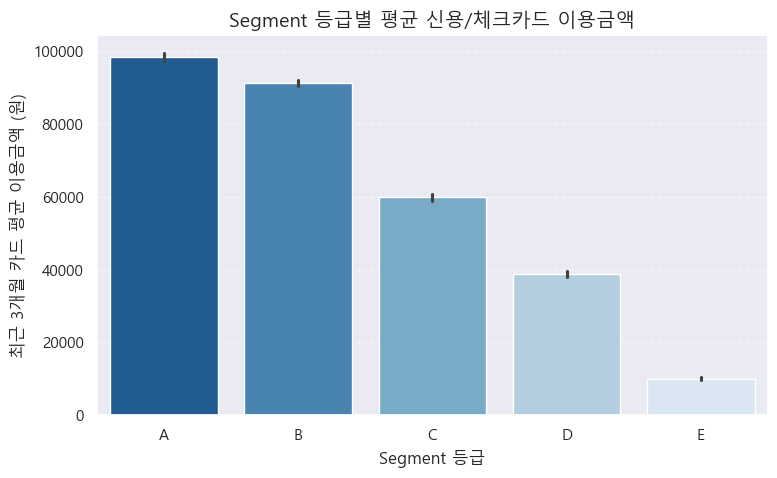

In [11]:
# Segment별 평균 이용금액 bar plot
# Segment 순서 정렬을 위해 카테고리형으로 지정
df_sampled['Segment'] = pd.Categorical(df_sampled['Segment'], categories=['A', 'B', 'C', 'D', 'E'], ordered=True)

# 평균 이용금액 계산 후 Bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x='Segment', y='이용금액_R3M_신용체크', data=df_sampled, estimator='mean', palette='Blues_r')

plt.title('Segment 등급별 평균 신용/체크카드 이용금액', fontsize=14)
plt.xlabel('Segment 등급')
plt.ylabel('최근 3개월 카드 평균 이용금액 (원)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

- A등급에서 E등급으로 갈수록 평균 이용금액이 눈에 띄게 감소
- 즉, Segment등급이 높을 수록 카드 사용이 많음

### Boxplot

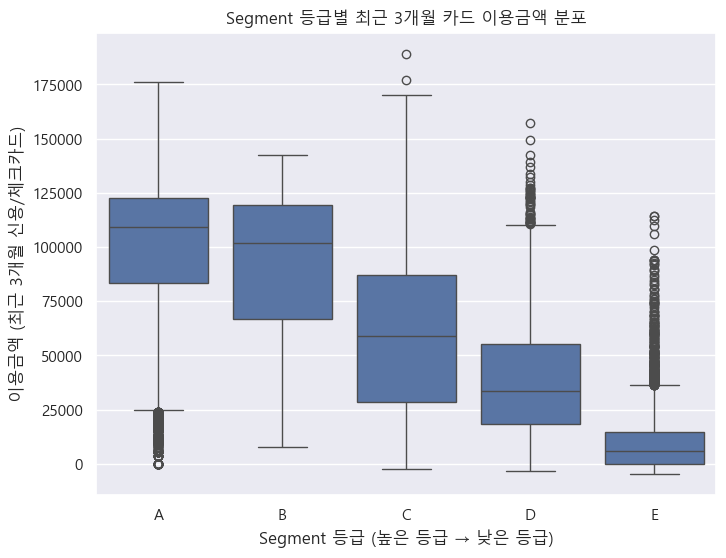

In [22]:
# Segment 등급 순서 지정 (A부터 E)
segment_order = ['A', 'B', 'C', 'D', 'E']

plt.figure(figsize=(8,6))
sns.boxplot(x='Segment', y='이용금액_R3M_신용체크', data=df_sampled, order=segment_order)
plt.title('Segment 등급별 최근 3개월 카드 이용금액 분포')
plt.xlabel('Segment 등급 (높은 등급 → 낮은 등급)')
plt.ylabel('이용금액 (최근 3개월 신용/체크카드)')
plt.show()

- 등급 B를 제외한 나머지 등급들에서 이상치가 다수 발견됨.